In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, f1_score

In [150]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 1. Import Data

In [151]:
link1 = 'https://assets.datacamp.com/production/repositories/3879/datasets/bdbbd97f839ef5cafebcc15363201d0e7b08881a/marketing.csv'
mkt = pd.read_csv(link1)
print(mkt.head())

      user_id date_served marketing_channel          variant converted  \
0  a100000029      1/1/18         House Ads  personalization      True   
1  a100000030      1/1/18         House Ads  personalization      True   
2  a100000031      1/1/18         House Ads  personalization      True   
3  a100000032      1/1/18         House Ads  personalization      True   
4  a100000033      1/1/18         House Ads  personalization      True   

  language_displayed language_preferred    age_group date_subscribed  \
0            English            English   0-18 years          1/1/18   
1            English            English  19-24 years          1/1/18   
2            English            English  24-30 years          1/1/18   
3            English            English  30-36 years          1/1/18   
4            English            English  36-45 years          1/1/18   

  date_canceled subscribing_channel is_retained  
0           NaN           House Ads        True  
1           NaN       

## 2. Insights from Datasets and Feature Engineering

### 2.1. Shape of dataset

In [152]:
# Check the count of overvations and features
mkt.shape

(10037, 12)

### 2.2. Statistics Summary

In [153]:
# Print the statistics of all columns
print(mkt.describe())

           user_id date_served marketing_channel  variant converted  \
count        10037       10021             10022    10037     10022   
unique        7309          31                 5        2         2   
top     a100000882     1/15/18         House Ads  control     False   
freq            12         789              4733     5091      8946   

       language_displayed language_preferred    age_group date_subscribed  \
count               10037              10037        10037            1856   
unique                  4                  4            7              31   
top               English            English  19-24 years         1/16/18   
freq                 9793               9275         1682             163   

       date_canceled subscribing_channel is_retained  
count            577                1856        1856  
unique           115                   5           2  
top           4/2/18           Instagram        True  
freq              15                 6

### 2.3. Data types and Non-missing value count

In [154]:
# Identify data types and number of non-missing values
print(mkt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   variant              10037 non-null  object
 4   converted            10022 non-null  object
 5   language_displayed   10037 non-null  object
 6   language_preferred   10037 non-null  object
 7   age_group            10037 non-null  object
 8   date_subscribed      1856 non-null   object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  1856 non-null   object
 11  is_retained          1856 non-null   object
dtypes: object(12)
memory usage: 941.1+ KB
None


In [155]:
# Change the data type of 'converted'
mkt['converted'] = mkt['converted'].astype('bool')
print(mkt['converted'].dtype)

bool


In [156]:
# Change data type of is_retained
# Convert is_retained to a boolean
mkt['is_retained'] = mkt['is_retained'].astype('bool')

# Check the data type of is_retained, again
print(mkt['is_retained'].dtype)

bool


By changing the data type to boolean, we can now sum the is_retained column to calculate the number of users who were retained

### 2.4. Create new columns

* Create 'is_house_ads' column to have a column that identifies if a particular marketing asset was a house ad or not

In [157]:
# Create new column 'is_house_ads'
mkt['is_house_ads'] = np.where(mkt['marketing_channel'] == 'House Ads', True, False)
print(mkt['is_house_ads'].head())

0    True
1    True
2    True
3    True
4    True
Name: is_house_ads, dtype: bool


* Create 'channel_code' to represent the numeric value of the subscribing channel

In [158]:
# Mapping for channels
channel_dict = {"House Ads": 1, "Instagram": 2, 
                "Facebook": 3, "Email": 4, "Push": 5}

# Map the channel to a channel code
mkt['channel_code'] = mkt['subscribing_channel'].map(channel_dict)
print(mkt['channel_code'].head())

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: channel_code, dtype: float64


* Create 'is_correct_lang' to convey whether the ad was shown to the user in their preferred language

In [159]:
# Create new column 'is_correct_lang'
mkt['is_correct_lang'] = np.where(mkt['language_preferred'] == mkt['language_displayed'], True, False)
print(mkt['is_correct_lang'].head())

0    True
1    True
2    True
3    True
4    True
Name: is_correct_lang, dtype: bool


### 2.5. Date column

Currently, the date columns in the marketing DataFrame are being incorrectly read as objects. We need to convert these columns to date columns to be able to use Python and pandas' robust date manipulation and formatting capabilities.

In [160]:
# Convert date_served', 'date_subscribed','date_canceled' to date type
mkt['date_served'] = pd.to_datetime(mkt['date_served'])

mkt['date_subscribed'] = pd.to_datetime(mkt['date_subscribed'])

mkt['date_canceled' ] = pd.to_datetime(mkt['date_canceled' ])

print(mkt[['date_served', 'date_subscribed','date_canceled']].head())


  date_served date_subscribed date_canceled
0  2018-01-01      2018-01-01           NaT
1  2018-01-01      2018-01-01           NaT
2  2018-01-01      2018-01-01           NaT
3  2018-01-01      2018-01-01           NaT
4  2018-01-01      2018-01-01           NaT


/var/folders/fq/ht56szt57xg5bz7rydss50y80000gp/T/ipykernel_2149/3873241010.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mkt['date_served'] = pd.to_datetime(mkt['date_served'])
/var/folders/fq/ht56szt57xg5bz7rydss50y80000gp/T/ipykernel_2149/3873241010.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mkt['date_subscribed'] = pd.to_datetime(mkt['date_subscribed'])
/var/folders/fq/ht56szt57xg5bz7rydss50y80000gp/T/ipykernel_2149/3873241010.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mkt['date_canceled' ] = pd.to_datetime(mkt['date_canceled' ])


In [161]:
# Create a day of week column from 'date_subscribed'
# Add a DoW column
mkt['DoW'] = mkt['date_subscribed'].dt.dayofweek
print(mkt['DoW'].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: DoW, dtype: float64


## 3. Exploratory Data Analysis

In [162]:
mkt.columns

Index(['user_id', 'date_served', 'marketing_channel', 'variant', 'converted',
       'language_displayed', 'language_preferred', 'age_group',
       'date_subscribed', 'date_canceled', 'subscribing_channel',
       'is_retained', 'is_house_ads', 'channel_code', 'is_correct_lang',
       'DoW'],
      dtype='object')

In [163]:
mkt.shape

(10037, 16)

### 3.1. How many users see marketing assets?

This is crucial to understand how effective our marketing efforts have been over the past month.

In [164]:
# Aggregate unique users that see ads by date
daily_users = mkt.groupby(['date_served'])['user_id'].nunique()
print(daily_users.head())

date_served
2018-01-01    362
2018-01-02    374
2018-01-03    348
2018-01-04    323
2018-01-05    319
Name: user_id, dtype: int64


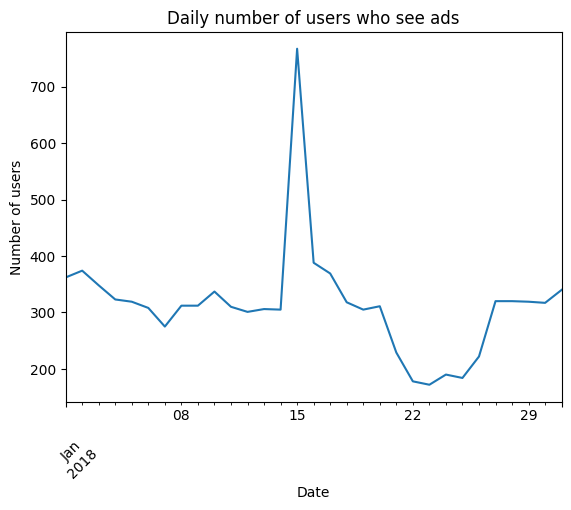

In [165]:
# Visualize the daily number of users who see the ads
daily_users.plot()
plt.title('Daily number of users who see ads')
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.xticks(rotation = 45)
plt.show()

Much like in daily users who view marketing assets, there's a large peak around the time when an email blast goes out. 

### 3.2. How effective a marketing team was at gaining new customers - Conversion rate

On marketing teams, conversion rate is typically the most important metric. It is one of the best ways to determine how effective a marketing team was at gaining new customers.

The formula for conversion rate = Number of people who convert / Total number of people who we market to

In [166]:
# Calculate the number of people we marketed to
total = mkt['user_id'].nunique()

# Calculate the number of people who subscribed
subscribers = mkt[mkt['converted'] == True]['user_id'].nunique()

# Calculate the conversion rate
conversion_rate = subscribers/total
print(round(conversion_rate*100, 2), "%")

14.09 %


### 3.3. Retention rate

To calculate the retention rate, or the number of remaining subscribers from the users who converted to your product. This can give a sense of whether your marketing campaign converted subscribers who were actually interested in the product.

Conversion rate and retention rate function hand-in-hand; we could create a business with a high conversion rate by giving users a free trial, but have a low retention rate once users are charged for the services. This isn't inherently a bad thing, but it is important to provide the business stakeholders with insight into what percentage of users remain subscribers.

The formula for retention rate = Number of people who remain subscribed / Total number of people who converted


In [167]:
# Calculate the number of subscribers
total_subscribers = mkt[mkt['converted'] == True]['user_id'].nunique()

# Calculate the number of people who remained subscribed
retained = mkt[mkt['is_retained'] == True]['user_id'].nunique()

# Calculate the retention rate
retention_rate = retained/total_subscribers
print(round(retention_rate * 100, 2), "%")

676.41 %


### 3.4. The retention rate of users who converted by clicking on a House Ad

In [168]:
# Subset to include only House Ads
house_ads = mkt[mkt['subscribing_channel'] == 'House Ads']
retained = house_ads[house_ads['is_retained'] == True]['user_id'].nunique()
subscribers = house_ads[house_ads['converted'] == True]['user_id'].nunique()

# Calculate retention rate
ret_rate = retained/subscribers
print('The retention rate of users who converted by clicking on a House Ad is: ', round(ret_rate * 100, 2), '%')

The retention rate of users who converted by clicking on a House Ad is:  58.05 %


### 3.5. The retention rate of each channel

In [169]:
# Calculate the retention rate of users by channel
retained = mkt[mkt['is_retained'] == True].groupby(['subscribing_channel'])['user_id'].nunique()
subcribers = mkt[mkt['converted'] == True].groupby(['subscribing_channel'])['user_id'].nunique()
channel_retention_rate = (retained/subscribers)* 100
print(channel_retention_rate)

subscribing_channel
Email        47.315436
Facebook     51.006711
House Ads    58.053691
Instagram    53.020134
Push         18.120805
Name: user_id, dtype: float64


### 3.6. The conversion rate of users who speak English

To know how effective the campaign was on converting English speakers.

In [170]:
# Isolate english speakers
english_speakers = mkt[mkt['language_displayed'] == 'English']

# Calculate the total number of English speaking users
total = mkt[mkt['language_displayed'] == 'English']['user_id'].nunique()

# Calculate the number of English speakers who converted
subscribers = english_speakers[english_speakers['converted'] == True]['user_id'].nunique()

# Calculate conversion rate
conversion_rate = subscribers/total
print('English speaker conversion rate:', round(conversion_rate*100,2), '%')

English speaker conversion rate: 13.13 %


### 3.7. Comparing language conversion rate 

Look at the conversion rate by the language that the marketing asset was shown in. While many of users speak English, some prefer another language. Let's check to make sure marketing material translated well across languages.

In [171]:
# Group by language_displayed and count unique users
total = mkt.groupby(['language_displayed'])['user_id'].nunique()

# Group by language_displayed and count unique conversions
subscribers = mkt[mkt['converted'] == True].groupby(['language_displayed'])['user_id'].nunique()

# Calculate the conversion rate for all languages
language_conversion_rate = subscribers/total*100
print(language_conversion_rate)

language_displayed
Arabic     50.000000
English    13.125959
German     71.621622
Spanish    20.000000
Name: user_id, dtype: float64


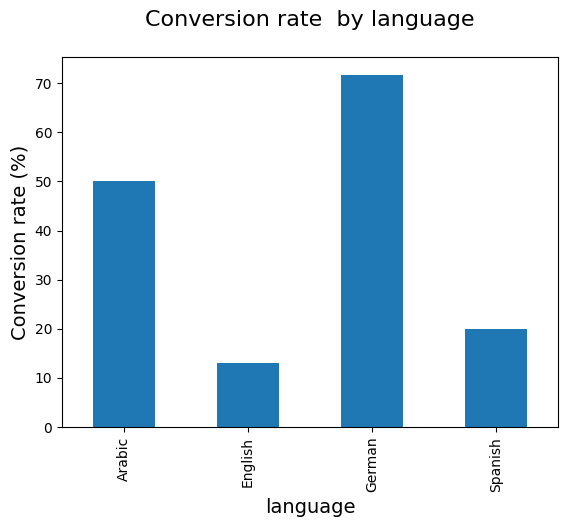

In [172]:
# Create bar chart using channel retention Dataframe
language_conversion_rate.plot(kind = 'bar')
plt.title('Conversion rate  by language\n', size = 16)
plt.xlabel('language', size = 14)
plt.ylabel('Conversion rate (%)', size = 14)
plt.show()

We notice the conversion rate is much lower for English and Spanish

### 3.8.  Is there any difference in the conversion rate based on when in the month?

In [173]:
# Group by date_served and count unique users
total = mkt.groupby(['date_served'])['user_id'].nunique()

# Group by date_served and count unique converted users
subscribers = mkt[mkt['converted'] == True].groupby(['date_served'])['user_id'].nunique()

# Calculate the conversion rate per day
daily_conversion_rate = subscribers/total
print(daily_conversion_rate)

date_served
2018-01-01    0.099448
2018-01-02    0.098930
2018-01-03    0.103448
2018-01-04    0.108359
2018-01-05    0.125392
2018-01-06    0.113636
2018-01-07    0.141818
2018-01-08    0.115385
2018-01-09    0.125000
2018-01-10    0.118694
2018-01-11    0.080645
2018-01-12    0.076412
2018-01-13    0.084967
2018-01-14    0.085246
2018-01-15    0.113429
2018-01-16    0.255155
2018-01-17    0.219512
2018-01-18    0.091195
2018-01-19    0.059016
2018-01-20    0.067524
2018-01-21    0.087336
2018-01-22    0.123596
2018-01-23    0.122093
2018-01-24    0.115789
2018-01-25    0.125000
2018-01-26    0.090090
2018-01-27    0.065625
2018-01-28    0.062500
2018-01-29    0.059561
2018-01-30    0.066246
2018-01-31    0.052941
Name: user_id, dtype: float64


In [174]:
# Reset index to turn the Series to Df
daily_conversion_rate = pd.DataFrame(daily_conversion_rate.reset_index())

# Rename columns
daily_conversion_rate.columns = ['date_subscribed', 'conversion_rate']
daily_conversion_rate.head()

,date_subscribed,conversion_rate
0,2018-01-01,0.099448
1,2018-01-02,0.098930
2,2018-01-03,0.103448
3,2018-01-04,0.108359
4,2018-01-05,0.125392


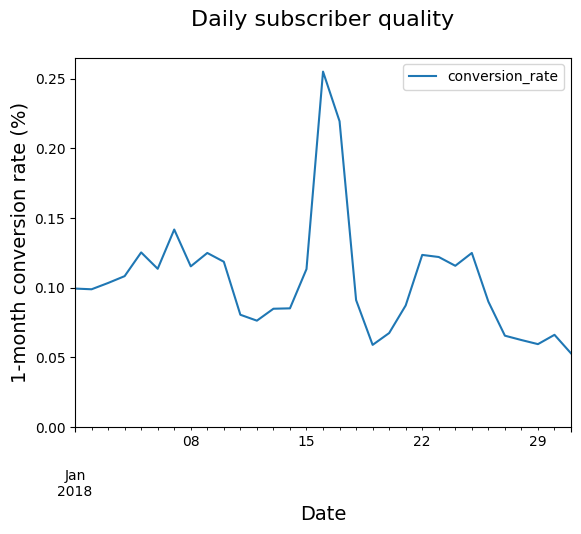

In [175]:
# Visualize data trended over time
daily_conversion_rate.plot('date_subscribed', 'conversion_rate')
plt.title('Daily subscriber quality\n', size = 16)
plt.ylabel('1-month conversion rate (%)', size = 14)
plt.xlabel('Date', size = 14)
# Set y-axis to begin at 0
plt.ylim(0)
plt.show()

### 3.9. The subscriber quality across dates

In [176]:
# Group by language_dispayed and count unique users
total = mkt.groupby(['date_subscribed'])['user_id'].nunique()

# Group by language_displayed and sum conversions
retained = mkt[mkt['is_retained'] == True].groupby(['date_subscribed'])['user_id'].nunique()

# Calculate subscriber quality across dates
daily_retention_rate =retained/total
print(daily_retention_rate)


date_subscribed
2018-01-01    0.777778
2018-01-02    0.702703
2018-01-03    0.729730
2018-01-04    0.500000
2018-01-05    0.575000
2018-01-06    0.756757
2018-01-07    0.526316
2018-01-08    0.638889
2018-01-09    0.675000
2018-01-10    0.682927
2018-01-11    0.615385
2018-01-12    0.391304
2018-01-13    0.500000
2018-01-14    0.615385
2018-01-15    0.714286
2018-01-16    0.701923
2018-01-17    0.616279
2018-01-18    0.733333
2018-01-19    0.684211
2018-01-20    0.809524
2018-01-21    0.761905
2018-01-22    0.772727
2018-01-23    0.714286
2018-01-24    0.652174
2018-01-25    0.565217
2018-01-26    0.800000
2018-01-27    0.571429
2018-01-28    0.666667
2018-01-29    0.750000
2018-01-30    0.714286
2018-01-31    0.666667
Name: user_id, dtype: float64


In [177]:
# Reset index to turn the Series to Df
daily_retention_rate = pd.DataFrame(daily_retention_rate.reset_index())

# Rename columns
daily_retention_rate.columns = ['date_subscribed', 'retention_rate']
daily_retention_rate.head()

,date_subscribed,retention_rate
0,2018-01-01,0.777778
1,2018-01-02,0.702703
2,2018-01-03,0.729730
3,2018-01-04,0.500000
4,2018-01-05,0.575000


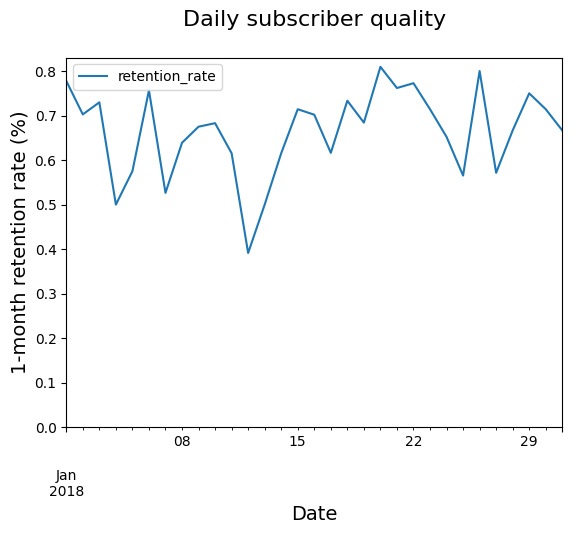

In [178]:
# Visualize data trended over time
daily_retention_rate.plot('date_subscribed', 'retention_rate')
plt.title('Daily subscriber quality\n', size = 16)
plt.ylabel('1-month retention rate (%)', size = 14)
plt.xlabel('Date', size = 14)
# Set y-axis to begin at 0
plt.ylim(0)
plt.show()

### 3.10. Preferred languages over time

In [179]:
# Group language over time
language = mkt.groupby(['date_served', 'language_preferred'])['user_id'].count()
print(language.head())

date_served  language_preferred
2018-01-01   Arabic                  4
             English               355
             German                  5
             Spanish                11
2018-01-02   Arabic                  4
Name: user_id, dtype: int64


In [180]:
# Create dataframe
language = pd.DataFrame(language.unstack(level=1))
language.head()


language_preferred,Arabic,English,German,Spanish
date_served,,,,
2018-01-01,4.0,355.0,5.0,11.0
2018-01-02,4.0,397.0,6.0,10.0
2018-01-03,3.0,374.0,3.0,8.0
2018-01-04,2.0,318.0,2.0,14.0
2018-01-05,1.0,314.0,2.0,14.0


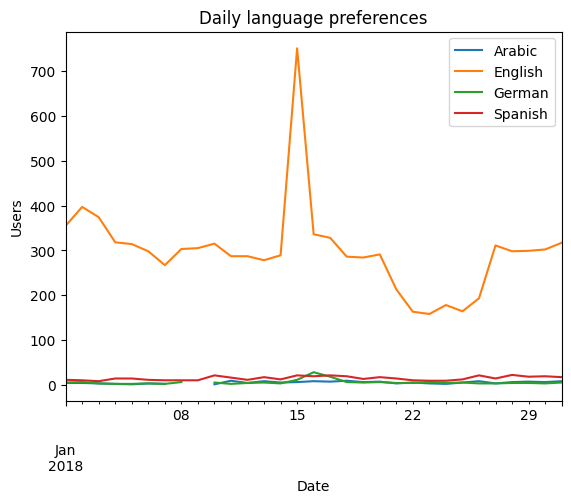

In [181]:
# Visualize preferred language over time
language.plot()
plt.title('Daily language preferences')
plt.xlabel('Date')
plt.ylabel('Users')
plt.legend(loc = 'upper right', labels = language.columns.values)
plt.show()

### 3.11. Preferred language by age group

In [182]:
# Create Dataframe grouped by age and language
language_age = mkt.groupby(['language_preferred', 'age_group'])['user_id'].count()
language_age = pd.DataFrame(language_age.unstack(level = 1))
language_age.head()

age_group,0-18 years,19-24 years,24-30 years,30-36 years,36-45 years,45-55 years,55+ years
language_preferred,,,,,,,
Arabic,19,26,19,19,19,21,22
English,1421,1560,1442,1251,1260,1240,1101
German,31,29,35,16,19,25,12
Spanish,68,67,72,69,55,67,52


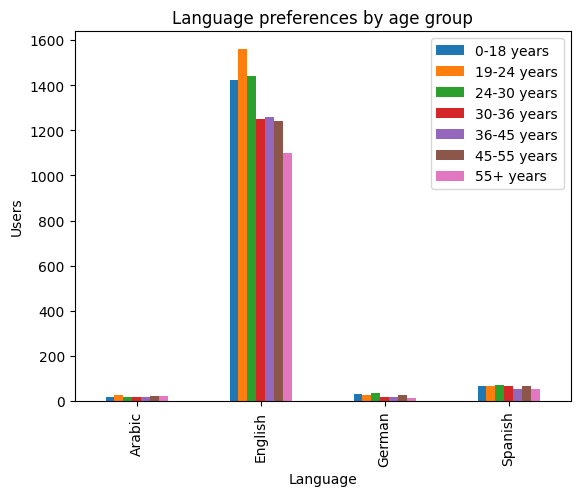

In [183]:
# Visualize langugae preferences by age group
language_age.plot(kind = 'bar')
plt.title('Language preferences by age group')
plt.xlabel('Language')
plt.ylabel('Users')
plt.legend(loc = 'upper right', labels = language_age.columns.values)
plt.show()

### 3.12. Marketing channels across age groups

In [184]:
# Create Dataframe grouped by age and marketing channels
channel_age = mkt.groupby(['marketing_channel', 'age_group'])\
                                ['user_id'].count()

# Unstack channel_age and transform it into a DataFrame
channel_age = pd.DataFrame(channel_age.unstack(level = 1))
channel_age.head()

age_group,0-18 years,19-24 years,24-30 years,30-36 years,36-45 years,45-55 years,55+ years
marketing_channel,,,,,,,
Email,93,111,120,60,63,65,53
Facebook,264,347,296,249,226,299,179
House Ads,694,761,681,699,589,678,631
Instagram,300,315,286,259,280,227,204
Push,186,145,183,86,193,82,118


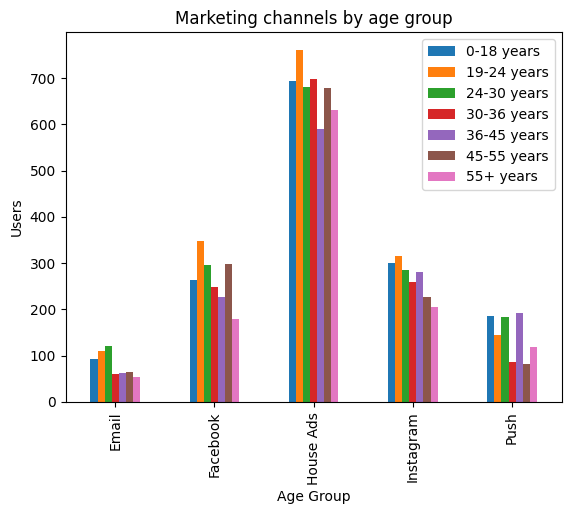

In [185]:
# Plot channel_age
channel_age.plot(kind = 'bar')
plt.title('Marketing channels by age group')
plt.xlabel('Age Group')
plt.ylabel('Users')
# Add a legend to the plot
plt.legend(loc = 'upper right', 
           labels = channel_age.columns.values)
plt.show()

### 3.13. The retention rate for the campaign

Stakeholders have begun competing to see whose channel had the best retention rate from the campaign. 

It's important to identify how each marketing channel is performing because this will affect company strategy going forward. If one channel is outperforming others, it might signal the channel merits further investment.

In [186]:
# Count the subs by subscribing channel and day
retention_total = mkt.groupby(['date_subscribed',
                                     'subscribing_channel'])['user_id'].nunique()

# Print results
print(retention_total.head())

date_subscribed  subscribing_channel
2018-01-01       Email                   1
                 Facebook                8
                 House Ads              16
                 Instagram               8
                 Push                    3
Name: user_id, dtype: int64


In [187]:
# Sum the retained subs by subscribing channel and date subscribed
retention_subs = mkt[mkt['is_retained'] == True].groupby(['date_subscribed', 
                                       'subscribing_channel'])['user_id'].nunique()

# Print results
print(retention_subs.head())

date_subscribed  subscribing_channel
2018-01-01       Email                   1
                 Facebook                7
                 House Ads              11
                 Instagram               6
                 Push                    3
Name: user_id, dtype: int64


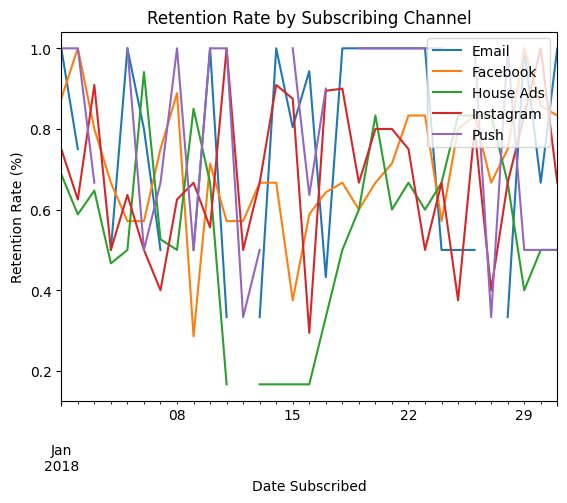

In [188]:
# Divide retained subscribers by total subscribers
retention_rate = retention_subs/retention_total
retention_rate_df = pd.DataFrame(retention_rate.unstack(level=1))

# Plot retention rate
retention_rate_df.plot()

# Add a title, x-label, y-label, legend and display the plot
plt.title('Retention Rate by Subscribing Channel')
plt.xlabel('Date Subscribed')
plt.ylabel('Retention Rate (%)')
plt.legend(loc = 'upper right', labels = retention_rate_df.columns.values)
plt.show()

### 3.14. The retention rate for the campaign - Building function for automate analysis

In [189]:
# Create a retention function
def retention_rate(df, cols):
    retained = df[df['is_retained'] == True].groupby(cols)['user_id'].nunique()
    converted = df[df['converted'] == True].groupby(cols)['user_id'].nunique()
    total_users = df.groupby(cols)['user_id'].nunique()
    retention_rate = retained / total_users
    return retention_rate 

In [190]:
# Create plotting function
def plotting(df):
    for column in df.columns:
        plt.plot(df.index, df[column])
        plt.title('Daily ' + column + ' retention rate\n', size=16)
        plt.ylabel('Retention rate (%)', size=14)
        plt.xlabel('Date', size=14)
        plt.show()

* Retention rate by subscribing channels

In [191]:
daily_retention = retention_rate(mkt, ['date_subscribed', 'subscribing_channel'])
daily_retention = pd.DataFrame(daily_retention.unstack(level = 1))
print(daily_retention.head())

subscribing_channel  Email  Facebook  House Ads  Instagram      Push
date_subscribed                                                     
2018-01-01            1.00  0.875000   0.687500   0.750000  1.000000
2018-01-02            0.75  1.000000   0.588235   0.625000  1.000000
2018-01-03             NaN  0.800000   0.647059   0.909091  0.666667
2018-01-04            0.50  0.666667   0.466667   0.500000       NaN
2018-01-05            1.00  0.571429   0.500000   0.636364  1.000000


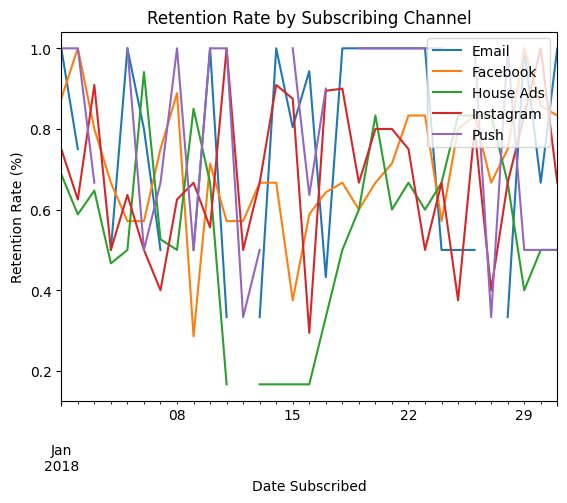

In [192]:
# Plot retention rate
daily_retention.plot()

# Add a title, x-label, y-label, legend and display the plot
plt.title('Retention Rate by Subscribing Channel')
plt.xlabel('Date Subscribed')
plt.ylabel('Retention Rate (%)')
plt.legend(loc = 'upper right', labels = daily_retention.columns.values)
plt.show()

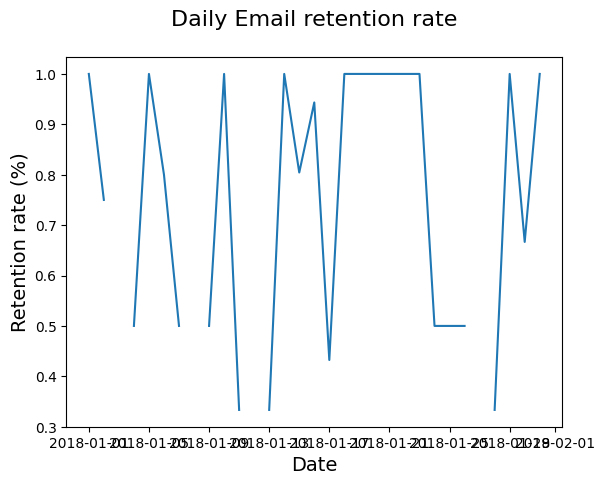

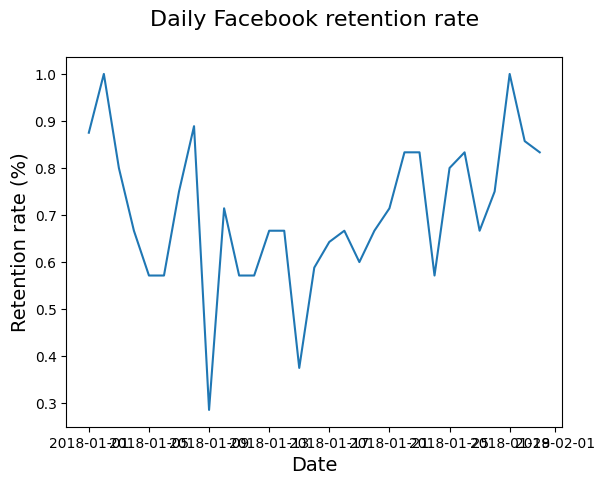

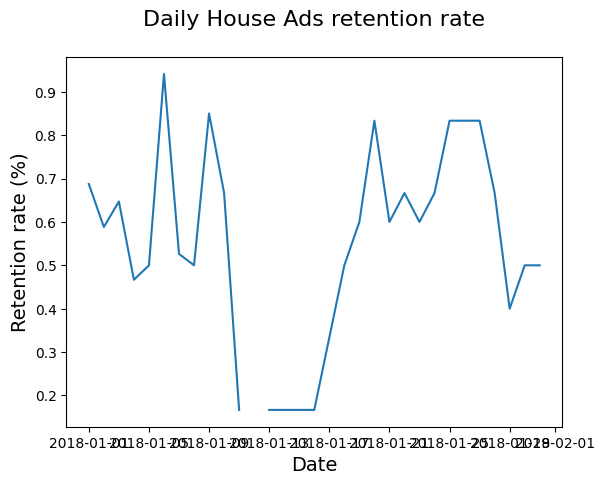

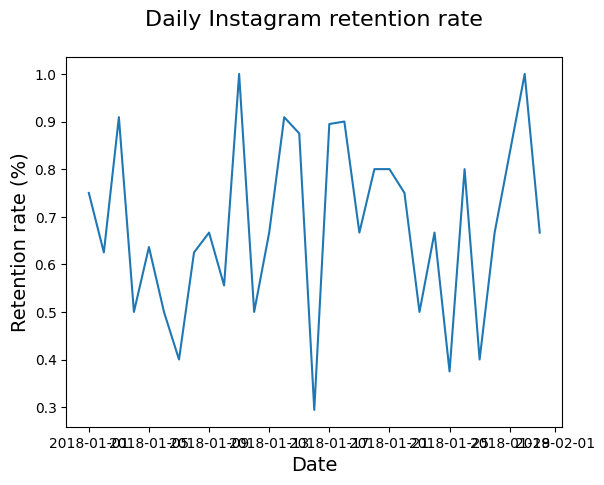

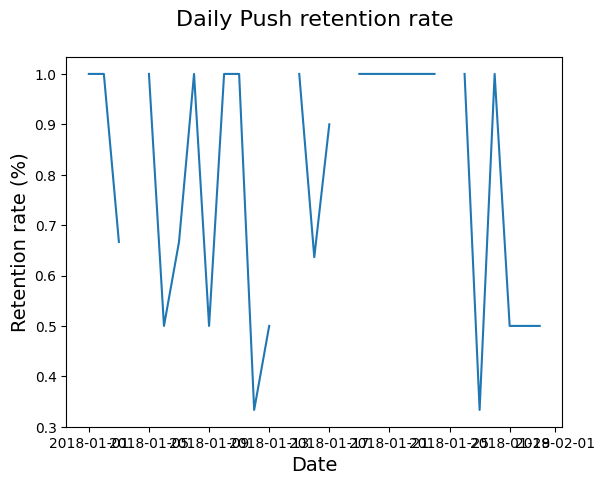

In [193]:
plotting(daily_retention)

### 3.15. The conversion rate by age groups

In [194]:
# Create a convertion function
def conversion_rate(df, cols):
    converted = df[df['converted'] == True].groupby(cols)['user_id'].nunique()
    total_users = df.groupby(cols)['user_id'].nunique()
    conversion_rate = converted / total_users
    conversion_rate = conversion_rate.fillna(0)
    return conversion_rate 

In [195]:
# Create plotting function
def plotting_conv(df):
    for column in df.columns:
        plt.plot(df.index, df[column])
        plt.title('Daily ' + str(column) + ' conversion rate\n', size = 16)
        plt.ylabel('Conversion rate', size = 14)
        plt.xlabel('Date', size = 14)
        plt.show()
        plt.clf()

date_served  age_group  
2018-01-01   0-18 years     0.155172
             19-24 years    0.196721
             24-30 years    0.105263
             30-36 years    0.040816
             36-45 years    0.042553
                              ...   
2018-01-31   24-30 years    0.057692
             30-36 years    0.000000
             36-45 years    0.035088
             45-55 years    0.023256
             55+ years      0.026316
Name: user_id, Length: 217, dtype: float64


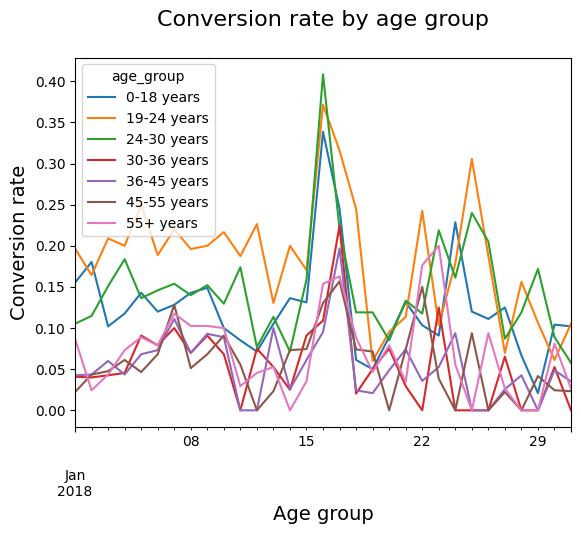

In [196]:
# Calculate conversion rate by age_group
age_group_conv = conversion_rate(mkt, ['date_served', 'age_group'])
print(age_group_conv)

# Unstack and create a DataFrame
age_group_df = pd.DataFrame(age_group_conv.unstack(level =1))

# Visualize conversion by age_group
age_group_df.plot()
plt.title('Conversion rate by age group\n', size = 16)
plt.ylabel('Conversion rate', size = 14)
plt.xlabel('Age group', size = 14)
plt.show()

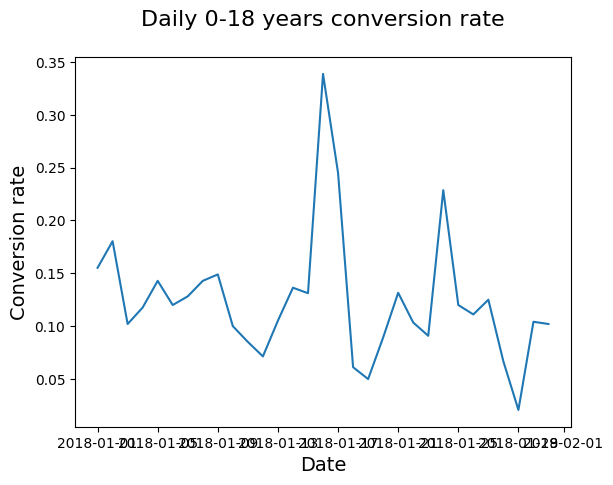

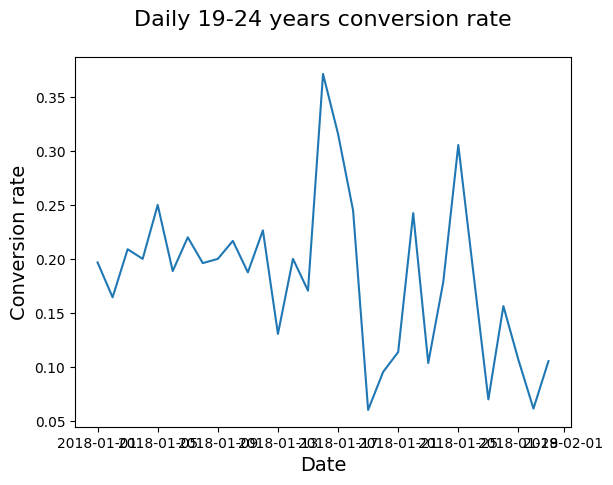

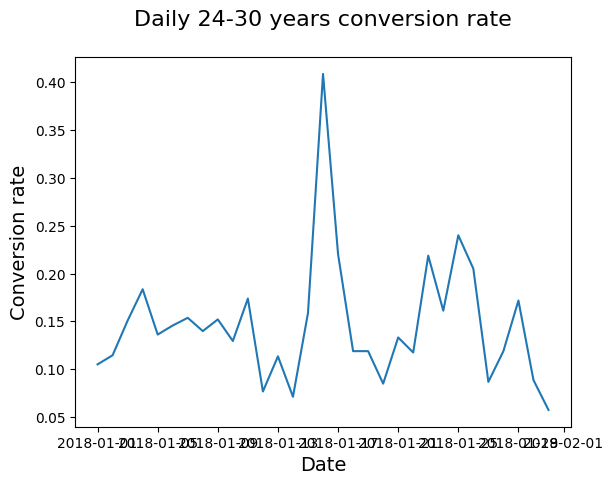

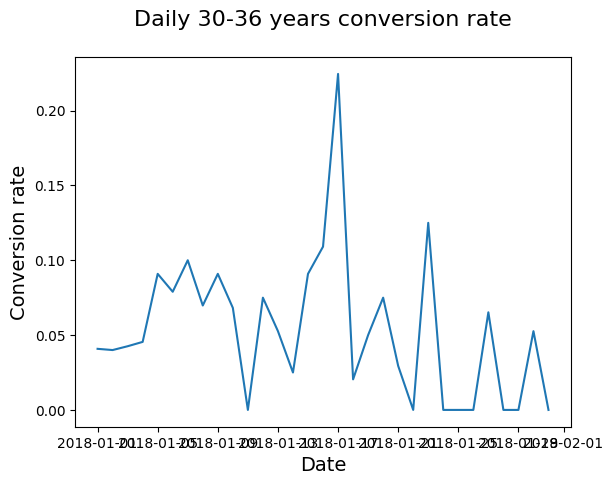

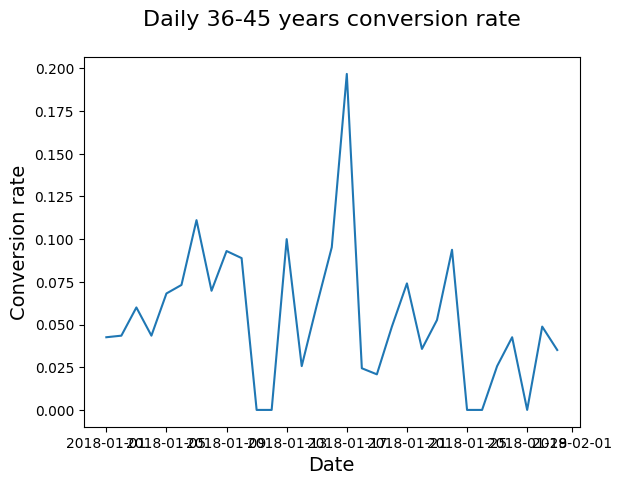

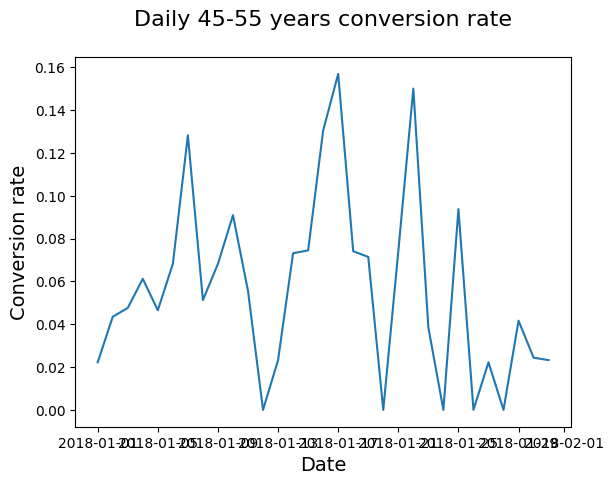

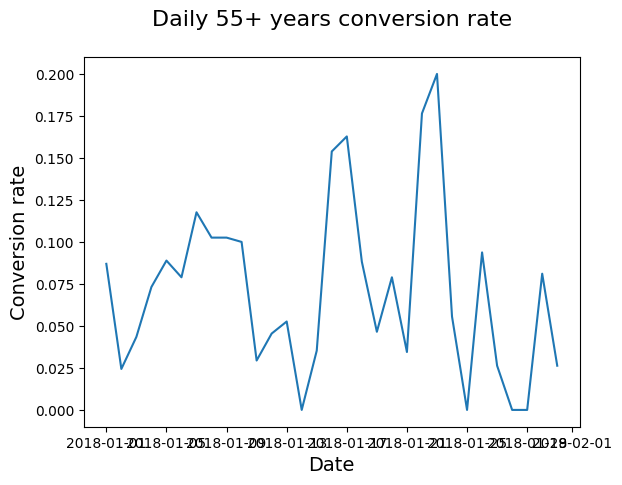

<Figure size 640x480 with 0 Axes>

In [197]:
plotting_conv(age_group_df)

### 3.16. Day of week trends

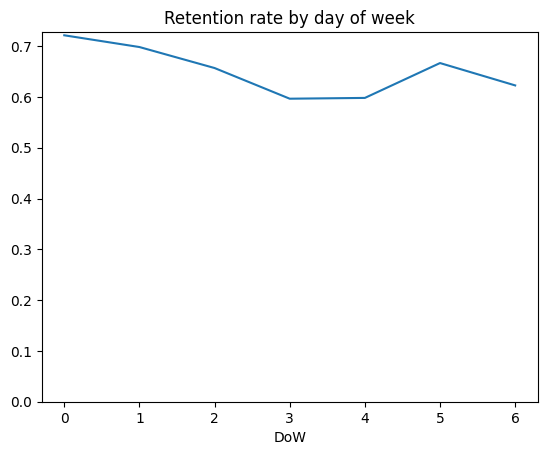

In [198]:
DoW_retention = retention_rate(mkt, ['DoW'])
DoW_retention.plot()
plt.title('Retention rate by day of week')
plt.ylim(0)
plt.show()

### 3.17. House ads conversion rate

The house ads team has become worried about some irregularities they've noticed in conversion rate. It is common for stakeholders to come to you with concerns they've noticed around changing metrics.

In [199]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(mkt, ['date_served', 'marketing_channel'])

print(daily_conv_channel.head())

date_served  marketing_channel
2018-01-01   Email                1.000000
             Facebook             0.117647
             House Ads            0.084656
             Instagram            0.106667
             Push                 0.083333
Name: user_id, dtype: float64


<Axes: xlabel='date_served'>

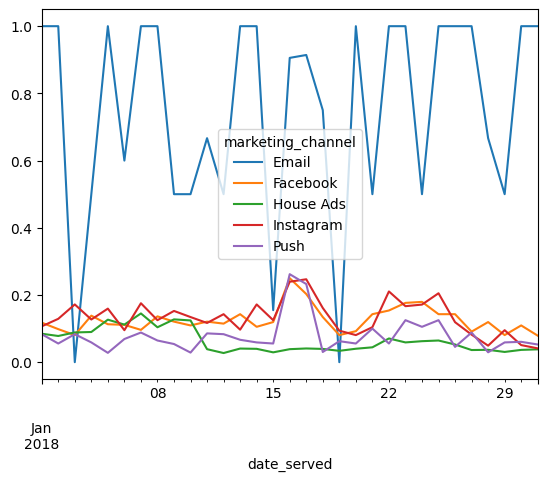

In [200]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(mkt, ['date_served', 
                                                 'marketing_channel'])

# Unstack daily_conv_channel and convert it to a DataFrame
daily_conv_channel = pd.DataFrame(daily_conv_channel.unstack(level = 1))

# Plot results of daily_conv_channel
daily_conv_channel.plot()

### 3.18. Conversion rate by day of week

It has been confirmed that house ads conversion has been down since January 11, we will try to identify potential causes for the decrease.

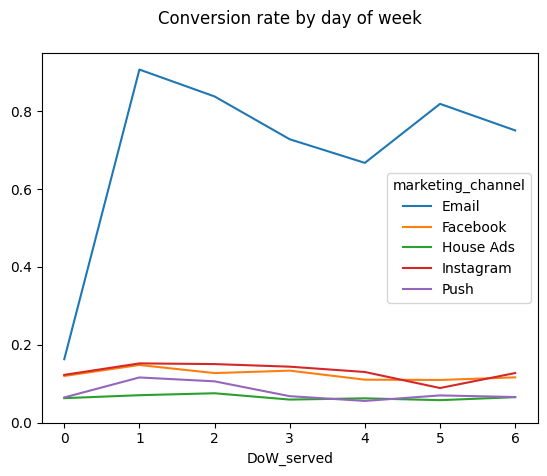

In [201]:
# Add day of week column to marketing
mkt['DoW_served'] = mkt['date_served'].dt.dayofweek

# Calculate conversion rate by day of week
DoW_conversion = conversion_rate(mkt, ['DoW_served', 'marketing_channel'])


# Unstack channels
DoW_df = pd.DataFrame(DoW_conversion.unstack(level=1))

# Plot conversion rate by day of week
DoW_df.plot()
plt.title('Conversion rate by day of week\n')
plt.ylim(0)
plt.show()

 Email is particularly high and may be reflective of a tracking error, but house ads appear stable across the week with a slight peak on Tuesday.

### 3.19. House ads conversion by language

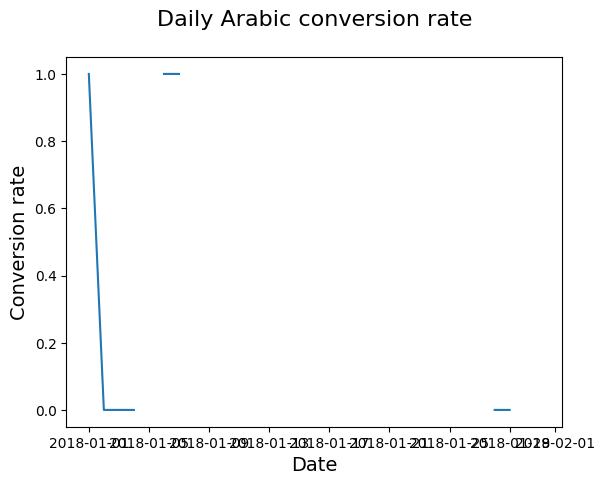

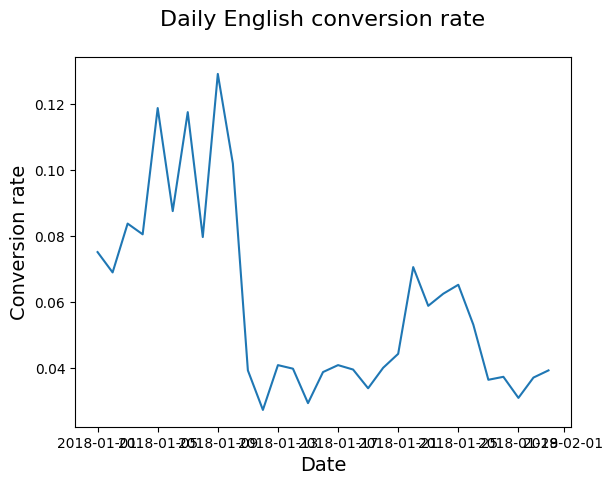

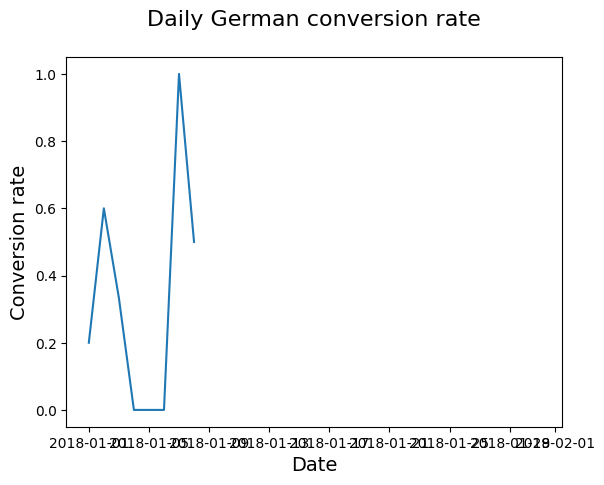

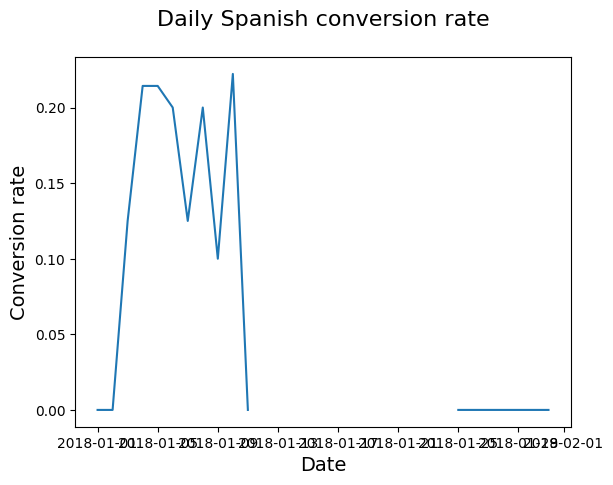

<Figure size 640x480 with 0 Axes>

In [202]:
# Isolate the rows where marketing channel is House Ads
house_ads = mkt[mkt['marketing_channel'] == 'House Ads']

# Calculate conversion by date served, and language displayed
conv_lang_channel = conversion_rate(house_ads, ['date_served', 'language_displayed'])

# Unstack conv_lang_channel
conv_lang_df = pd.DataFrame(conv_lang_channel.unstack(level=1))

# Use your plotting function to display results
plotting_conv(conv_lang_df)

### 3.20. Confirming house ads error

Let's checks whether users see ads in the correct language

In [203]:
# Add the new column is_correct_lang
house_ads['is_correct_lang'] = np.where(house_ads['language_displayed'] == house_ads['language_preferred'], 'Yes', 'No')

# Groupby date_served and correct_language
language_check = house_ads.groupby(['date_served', 'is_correct_lang'])['user_id'].count()

# Unstack language_check and fill missing values with 0's
language_check_df = pd.DataFrame(language_check.unstack(level=1)).fillna(0)

# Print results
print(language_check_df)

is_correct_lang    No    Yes
date_served                 
2018-01-01        2.0  189.0
2018-01-02        3.0  247.0
2018-01-03        0.0  220.0
2018-01-04        0.0  168.0
2018-01-05        0.0  160.0
2018-01-06        1.0  151.0
2018-01-07        2.0  130.0
2018-01-08        0.0  154.0
2018-01-09        0.0  157.0
2018-01-10        0.0  170.0
2018-01-11       20.0  135.0
2018-01-12       18.0  130.0
2018-01-13       26.0  122.0
2018-01-14       20.0  131.0
2018-01-15       16.0  192.0
2018-01-16       28.0  127.0
2018-01-17       21.0  127.0
2018-01-18       31.0  121.0
2018-01-19       22.0  127.0
2018-01-20       28.0  124.0
2018-01-21       14.0  100.0
2018-01-22       13.0   72.0
2018-01-23       16.0   69.0
2018-01-24       13.0   83.0
2018-01-25       19.0   74.0
2018-01-26       24.0   92.0
2018-01-27       18.0  149.0
2018-01-28       28.0  136.0
2018-01-29       24.0  142.0
2018-01-30       23.0  145.0
2018-01-31       23.0  135.0


/var/folders/fq/ht56szt57xg5bz7rydss50y80000gp/T/ipykernel_2149/4188544111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_ads['is_correct_lang'] = np.where(house_ads['language_displayed'] == house_ads['language_preferred'], 'Yes', 'No')


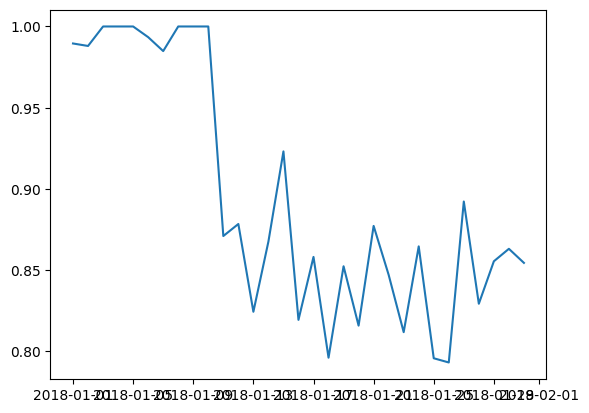

In [204]:
# Divide the count where language is correct by the row sum
language_check_df['pct'] = language_check_df['Yes']/language_check_df.sum(axis=1)

# Plot and show your results
plt.plot(language_check_df.index.values, language_check_df['pct'])
plt.show()

### 3.21. Resolving inconsistencies

In [205]:
# Calculate pre-error conversion rate 
# Bug arose sometime around '2018-01-11'
house_ads_no_bug = house_ads[house_ads['date_served'] < '2018-01-11']
lang_conv = conversion_rate(house_ads_no_bug, ['language_displayed'])

# Index other language conversion rate against English
spanish_index = lang_conv['Spanish']/lang_conv['English']
arabic_index = lang_conv['Arabic']/lang_conv['English']
german_index = lang_conv['German']/lang_conv['English']

print('Spanish index: ', spanish_index)
print('Arabic index: ', arabic_index)
print('German index: ', german_index)


Spanish index:  1.681924882629108
Arabic index:  5.045774647887324
German index:  4.485133020344287


* Daily conversion

In [206]:
# Create actual conversion df
language_conversion = house_ads.groupby(['date_served', 'language_preferred']).agg({'user_id': 'nunique', 'converted': 'sum'})
language_conversion = pd.DataFrame(language_conversion.unstack(level = 1))

language_conversion.head()

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0       2.0    13.0    1.0   
2018-01-02             3.0   200.0    5.0    10.0       0.0    14.0    3.0   
2018-01-03             2.0   179.0    3.0     8.0       0.0    15.0    1.0   
2018-01-04             2.0   149.0    2.0    14.0       0.0    12.0    0.0   
2018-01-05             NaN   143.0    1.0    14.0       NaN    17.0    0.0   

                            
language_preferred Spanish  
date_served                 
2018-01-01             0.0  
2018-01-02             0.0  
2018-01-03             1.0  
2018-01-04             3.0  
2018-01-05             3.0

In [207]:
# Create English conversion rate column for affected period
language_conversion['actual_english_converions'] = language_conversion.loc['2018-01-11':'2018-01-31'][('converted', 'English')]

# Create expected conversion rates for each language
language_conversion['expected_spanish_rate'] = language_conversion['actual_english_converions'] * spanish_index
language_conversion['expected_arabic_rate'] = language_conversion['actual_english_converions'] * arabic_index
language_conversion['expected_german_rate'] = language_conversion['actual_english_converions'] * german_index

# Calculate daily expected conversion
language_conversion['expected_spanish_rate'] = language_conversion['expected_spanish_rate']/100*language_conversion[('user_id', 'Spanish')]
language_conversion['expected_arabic_rate'] = language_conversion['expected_arabic_rate']/100*language_conversion[('user_id', 'Arabic')]
language_conversion['expected_german_rate'] = language_conversion['expected_german_rate']/100*language_conversion[('user_id', 'German')]

* Dertermining the number of lost subscribers

In [208]:
bug_period = language_conversion.loc['2018-01-11':'2018-01-31']

# Sum expected subscribers for each language
expected_subs = bug_period['expected_spanish_rate'].agg('sum') + bug_period['expected_arabic_rate'].agg('sum') + bug_period['expected_german_rate'].agg('sum')

# Calculate how many subsribers we actually got
actual_subs = bug_period[('converted', 'Spanish')].sum() + bug_period[('converted', 'Arabic')].sum() + bug_period[('converted', 'German')].sum() 

lost_subs = expected_subs - actual_subs
print(lost_subs)

32.14414319248826


## 4. Persionalization A/B Test

### 4.1. Test allocation

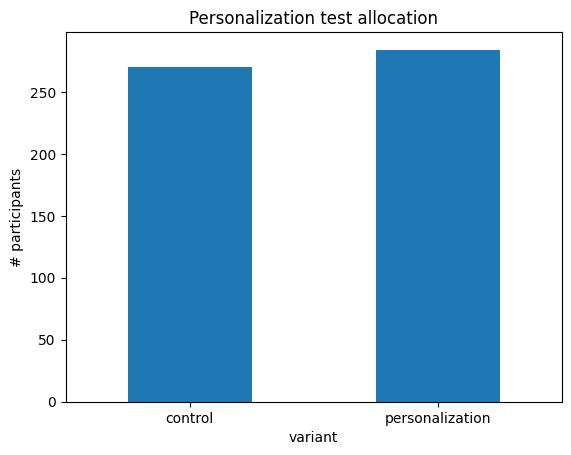

In [209]:
email = mkt[mkt['marketing_channel'] == 'Email']
allocation = email.groupby(['variant'])['user_id'].nunique()

# Visualize allocation
allocation.plot(kind = 'bar')
plt.title('Personalization test allocation')
plt.xticks(rotation = 0)
plt.ylabel('# participants')
plt.show()

* Setting up data to evaluate the test

In [210]:
# Group by user_id and variant
subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
subscribers = pd.DataFrame(subscribers.unstack(level = 1))

subscribers.head()

variant,control,personalization
user_id,,
a100000526,NaN,True
a100000530,NaN,True
a100000534,NaN,False
a100000538,NaN,True
a100000542,NaN,True


In [211]:
# Drop missing values from the control column
control = subscribers['control'].dropna()

# Drop missing values from personalization column
personalization = subscribers['personalization'].dropna()

# Conversion rate
print('Control conversion rate: ', np.mean(control))
print('Personalization conversion rate: ', np.mean(personalization))

Control conversion rate:  0.2814814814814815
Personalization conversion rate:  0.3908450704225352


### 4.2. Calculating lift and significance testing

Lift can be calculated by calculating the difference between the treatment effect (or the mean) of the treatment compared to the treatment effect of the control divided by the treatment effect of the control. The formula for lift can be found below:
(Treatment conversion rate – Control conversion rate) / Control conversion rate


* Calculating lift

In [212]:
# Calculate the mean of a and b
a_mean = np.mean(control)
b_mean = np.mean(personalization)

# Calculate the life using a_mean and b_mean
lift = (b_mean - a_mean)/a_mean

print('Lift: ', str(round(lift*100, 2))+ '%')

Lift:  38.85%


In [213]:
# Calculating lift by creating lift() funtion
def lift(a,b):
    # Calcuate the mean of a and b 
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    
    # Calculate the lift using a_mean and b_mean
    lift = (b_mean-a_mean)/a_mean
  
    return str(round(lift*100, 2)) + '%'
  
# Print lift() with control and personalization as inputs
print(lift(control, personalization))

38.85%


* T-test

In [214]:
print(control.dtype)
print(personalization.dtype)

object
object


In [215]:
control = control.astype(float)
personalization = personalization.astype(float)

In [216]:
from scipy.stats import ttest_ind

# Assuming control and personalization are arrays or lists containing sample data
t_statistic, p_value = ttest_ind(control, personalization)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -2.734329944750507
p-value: 0.006451487844694182


The results are statistically significant with p = 0.006.
The personalization results are highly statistically significant.

### 4.3. A/B testing and segmentation

In [219]:
# Personalization test segmented by language
for lang in np.unique(mkt['language_displayed'].values):
    print("Language:", lang)  # Print the language
    
    # Isolate the relevant data
    lang_data = mkt[(mkt['marketing_channel'] == 'Email') & (mkt['language_displayed'] == lang)]
    
    # Isolate subscribers
    subscribers = lang_data.groupby(['user_id', 'variant'])['converted'].max()
    
    # Isolate control and personalization
    sub = pd.DataFrame(subscribers.unstack(level=1))
    con = sub['control'].dropna().astype(float)
    per = sub['personalization'].dropna().astype(float)
    
    print('Lift:', lift(con, per))  # Assuming lift is a defined function
    print('t-statistic:', ttest_ind(con, per), '\n\n')

Language: Arabic
Lift: 50.0%
t-statistic: TtestResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001, df=8.0) 


Language: English
Lift: 39.0%
t-statistic: TtestResult(statistic=-2.2183598646203215, pvalue=0.026991701290720503, df=486.0) 


Language: German
Lift: -1.62%
t-statistic: TtestResult(statistic=0.19100834180787182, pvalue=0.8494394170062678, df=42.0) 


Language: Spanish
Lift: 166.67%
t-statistic: TtestResult(statistic=-2.3570226039551585, pvalue=0.04015671811047753, df=10.0) 




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


To build a function ab_segmentation() that analyzes the impact of your A/B tests on segments of data that we can reuse each time we want to conduct this kind of analysis.

In [228]:
def ab_segmentation(segment):
      # Build a for loop for each segment in marketing
  for subsegment in np.unique(mkt[segment].values):
      print(subsegment)
      
      # Limit marketing to email and subsegment      
      email = mkt[(mkt['marketing_channel'] == 'Email') & (mkt[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
      control = subscribers['control'].dropna().astype(float)
      personalization = subscribers['personalization'].dropna().astype(float)

      print('lift:', lift(control, personalization))
      print('t-statistic:', ttest_ind(control, personalization), '\n\n')

In [229]:
# Use ab_segmentation on language displayed
ab_segmentation('language_displayed')

Arabic
lift: 50.0%
t-statistic: TtestResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001, df=8.0) 


English
lift: 39.0%
t-statistic: TtestResult(statistic=-2.2183598646203215, pvalue=0.026991701290720503, df=486.0) 


German
lift: -1.62%
t-statistic: TtestResult(statistic=0.19100834180787182, pvalue=0.8494394170062678, df=42.0) 


Spanish
lift: 166.67%
t-statistic: TtestResult(statistic=-2.3570226039551585, pvalue=0.04015671811047753, df=10.0) 




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [230]:
# Use ab_segmentation on age group
ab_segmentation('age_group')

0-18 years
lift: 121.4%
t-statistic: TtestResult(statistic=-2.966044912142212, pvalue=0.003872449439129706, df=89.0) 


19-24 years
lift: 106.24%
t-statistic: TtestResult(statistic=-3.0317943847866697, pvalue=0.0030623836114689195, df=105.0) 


24-30 years
lift: 161.19%
t-statistic: TtestResult(statistic=-3.861539544326876, pvalue=0.00018743381094867337, df=114.0) 


30-36 years
lift: -100.0%
t-statistic: TtestResult(statistic=3.185906464414798, pvalue=0.002323848743176535, df=58.0) 


36-45 years
lift: -85.23%
t-statistic: TtestResult(statistic=2.431790127931851, pvalue=0.017975686009788244, df=61.0) 


45-55 years
lift: -72.22%
t-statistic: TtestResult(statistic=2.0654991273179326, pvalue=0.04306233968820124, df=62.0) 


55+ years
lift: -100.0%
t-statistic: TtestResult(statistic=3.326565456420339, pvalue=0.0016358623456360468, df=51.0) 




It was found that personalization was extremely effective for younger groups but less effective than the control for older groups. One explanation might be that younger users understand how their data might be used online and think personalization is cool because it gives them more insight into themselves while older people might feel that this is a violation of their privacy.